In [2]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')

import numpy as np
from analysis import analysis, emg, plot, model
import scipy as sp
from pathlib import Path
from scipy.stats import tukey_hsd

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

import matplotlib.pyplot as plt

image_path = Path("/Users/spencer/phd/phd/images/more_results/gmm_diffs/")

%matplotlib inline

In [3]:
subjects = analysis.load_subjects()

In [4]:
import pandas as pd
trajectory_df = pd.read_pickle("../trajectory_dataframe.pkl")
mean_rewards = 1 / trajectory_df.groupby(level=['subject']).mean()["reward"]

## total variance

In [5]:
# mean_total_variance = []
# mean_total_meannorm = []
# for subject_idx in range(len(subjects)):
#     log_models = model.load_log_trial_models(subject_idx)
#     tvm = 0
#     mvm = 0
#     for m in log_models:
#         tv = 0
#         mv = 0
#         for c in m.covariances_:
#             tv += np.trace(c)
#         for m in m.means_:
#             mv += np.linalg.norm(m)
#         tvm += tv
#         mvm += mv
#     mean_total_variance.append(tvm)
#     mean_total_meannorm.append(mvm)

In [6]:
# plt.plot(mean_rewards, mean_total_variance)
# plt.xlabel("Reward")
# plt.ylabel("Total GMM Variance")
# plt.figure()
# plt.plot(mean_total_meannorm, mean_total_variance)
# plt.xlabel("mean gmm mean norm")
# plt.ylabel("Total GMM Variance")

## euclidean diffs over models

In [7]:
subject_diffs = []
for subject_idx in range(len(subjects)):

    log_movement_models = model.load_log_movement_models(subject_idx)
    log_calibration_models = model.load_log_calibration_models(subject_idx)
    log_trial_models = model.load_log_trial_models(subject_idx)
    combined_log_models = log_movement_models + log_calibration_models + log_trial_models

    all_models = []
    for m in combined_log_models:
        all_models.append(model.log_model(m))

    model_diffs = []
    # closest means in the normal space
    model_mean_pairs = model.closest_pairs_euclidean(combined_log_models)
    for model_idx, mean_pair in enumerate(model_mean_pairs):
        component_diffs = []
        for i, component_pair in enumerate(mean_pair):
            # model x --> model y
            # paired components
            # frobenius in the lognormal space
            component_diffs.append(analysis.frobenius_difference(all_models[model_idx].covariances[component_pair[0]], all_models[model_idx+1].covariances[component_pair[1]]))
        model_diffs.append(component_diffs)
    subject_diffs.append(model_diffs)

frobenius_subject_diffs = np.array(subject_diffs) 
# diff_rewards = []
# mean_diffs = []
# for i, model_diffs in enumerate(subject_diffs):
#     diff_rewards.append(mean_rewards[i])
#     # mean of the differences between subsequent models
#     mean_diffs.append(np.mean(model_diffs))

In [8]:
frobenius_subject_diffs.shape

(46, 6, 12)

Text(0, 0.5, 'Mean Frobenius Difference')

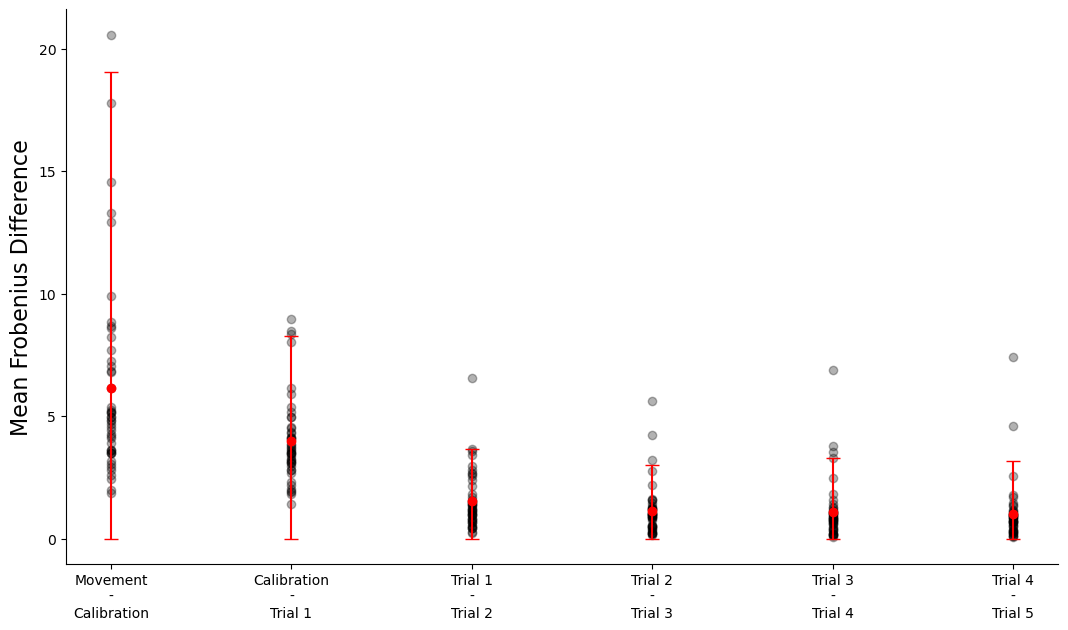

In [9]:
fig, ax = plt.subplots(1,1)
frobenius_subject_diffs[np.argmax(frobenius_subject_diffs.mean(axis=2)[:,0]),0,:] = frobenius_subject_diffs[:,0,:].mean()
ax.plot(frobenius_subject_diffs.mean(axis=2).T,"ko",alpha=0.3)
means = frobenius_subject_diffs.mean(axis=(0,2)).reshape(-1,1)
stds = frobenius_subject_diffs.std(axis=(0,2)).reshape(-1,1)
diffs = np.subtract(means,stds).reshape(-1,1)
lower_errors = np.zeros(shape=(frobenius_subject_diffs.shape[1],1))
lower_errors[diffs < 0] = means[diffs < 0]
lower_errors[diffs > 0] = stds[diffs > 0]
y_errors = [lower_errors.ravel(),stds.ravel()]
ax.errorbar(x=range(6),y=means.ravel(),yerr=y_errors,lolims=0,color="r",marker="o",capsize=5)
labels = ["Movement\n-\nCalibration","Calibration\n-\nTrial 1", "Trial 1\n-\nTrial 2", "Trial 2\n-\nTrial 3", "Trial 3\n-\nTrial 4", "Trial 4\n-\nTrial 5"]
ax.set_xticks(range(6))
ax.set_xticklabels(labels=labels)
ax.set_ylabel("Mean Frobenius Difference")

In [10]:
plot.save_figure(fig,"frobenius_over_tasks",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmm_diffs/frobenius_over_tasks.pdf


Figure saved to /Users/spencer/phd/phd/images/more_results/gmm_diffs/frobenius_over_tasks_pvalues.png


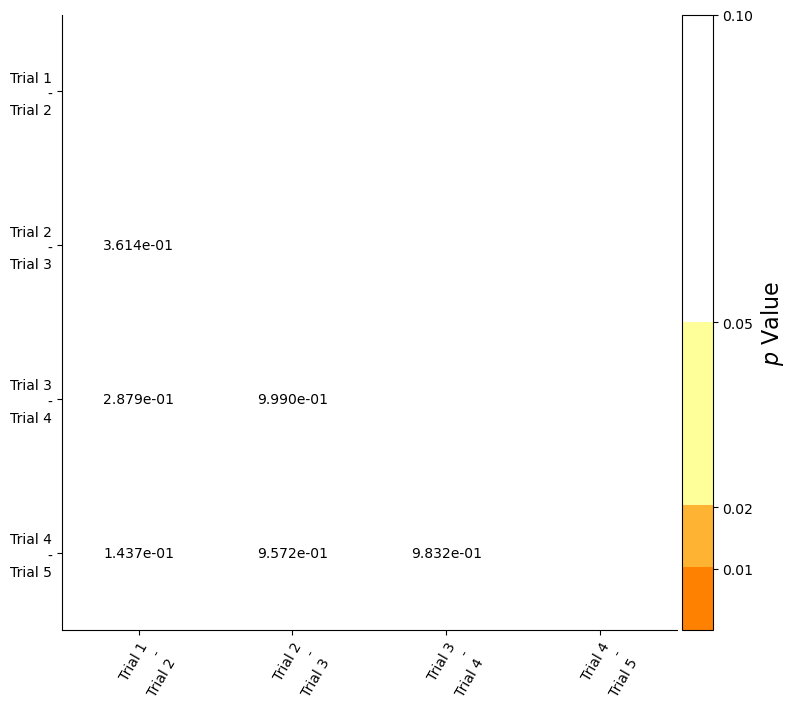

In [11]:
result = tukey_hsd(*frobenius_subject_diffs.mean(axis=2).T[2:])
fig, ax = plt.subplots(1,1)
plot.annotated_heatmap(result.pvalue,labels_x=labels[2:],labels_y=labels[2:],figax=(fig,ax))
plot.save_figure(fig,"frobenius_over_tasks_pvalues",image_path,format="png")

## compute euclidean diffs for each subject -- closest means, look at subsequent covariance differences

In [12]:
subject_diffs = []
for subject_idx in range(len(subjects)):
    log_models = model.load_log_trial_models(subject_idx)
    models = []
    for m in log_models:
        models.append(model.log_model(m))
    model_diffs = []
    # closest means in the normal space
    model_mean_pairs = model.closest_pairs_euclidean(log_models)
    for model_idx, mean_pair in enumerate(model_mean_pairs):
        component_diffs = []
        for i, component_pair in enumerate(mean_pair):
            # model x --> model y
            # paired components
            # frobenius in the lognormal space
            component_diffs.append(analysis.frobenius_difference(models[model_idx].covariances[component_pair[0]], models[model_idx+1].covariances[component_pair[1]]))
        model_diffs.append(component_diffs)
    subject_diffs.append(model_diffs)
    
diff_rewards = []
mean_diffs = []
for i, model_diffs in enumerate(subject_diffs):
    diff_rewards.append(mean_rewards[i])
    # mean of the differences between subsequent models
    mean_diffs.append(np.mean(model_diffs))

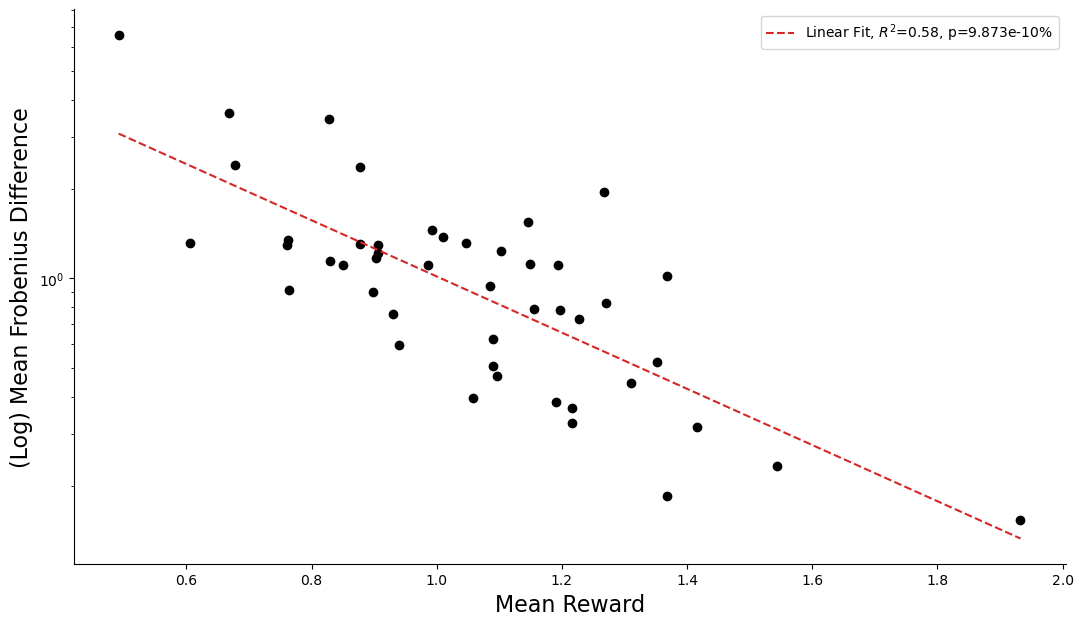

In [13]:
fig = plt.figure()
fig.tight_layout()
# plt.plot(diff_rewards,mean_diffs,"ro")
# norm_diff = [md/mtv for md, mtv in zip(mean_diffs,mean_total_variance)]
plt.semilogy(diff_rewards,mean_diffs,"ko")
r = analysis.linear_fit(diff_rewards,np.log(mean_diffs))
x = np.linspace(np.min(diff_rewards),np.max(diff_rewards),100)
plt.gca().plot(x, np.exp(r.intercept + r.slope*x),"--", color="tab:red", label=f"Linear Fit, $R^2$={plot.format_positional(r.rvalue**2)}, p={plot.format_scientific(r.pvalue)}%")
# plot.plot_linear_fit(x,r,plt.gca())
plt.ylabel("(Log) Mean Frobenius Difference")
plt.xlabel("Mean Reward")
# plt.ylim([0.0005,0.02])
plt.legend()

In [14]:
# fig = plt.figure()
# fig.tight_layout()
# norm_diff = [md/mtv for md, mtv in zip(mean_diffs,mean_total_variance)]
# plt.semilogy(diff_rewards,norm_diff,"ko")
# r = analysis.linear_fit(diff_rewards,np.log(norm_diff))
# x = np.linspace(np.min(diff_rewards),np.max(diff_rewards),100)
# plt.gca().plot(x, np.exp(r.intercept + r.slope*x),"--", color="tab:red", label=f"Linear Fit, $R^2$={plot.format_positional(r.rvalue**2)}, p={plot.format_scientific(r.pvalue)}%")
# plt.ylabel("Log Mean Inter-Mixture Frobenius Difference")
# plt.xlabel("Mean Reward")
# # plt.ylim([0.01,1])
# plt.legend()

In [15]:
plot.save_figure(fig, "mean_gmm_differences", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmm_diffs/mean_gmm_differences.pdf


## wasserstein pairs over time

In [35]:
subject_diffs = []
for subject_idx in range(len(subjects)):

    log_movement_models = model.load_log_movement_models(subject_idx)
    log_calibration_models = model.load_log_calibration_models(subject_idx)
    log_trial_models = model.load_log_trial_models(subject_idx)
    combined_log_models = log_movement_models + log_calibration_models + log_trial_models

    models = []
    for m in combined_log_models:
        models.append(model.log_model(m))

    model_diffs = []
    for model_idx in range(len(models)-1):
        # model x --> model y
        model_diffs.append(model.gmm_wasserstein(models[model_idx].weights,
                                                        models[model_idx+1].weights,
                                                        models[model_idx].means,
                                                        models[model_idx+1].means,
                                                        models[model_idx].covariances,
                                                        models[model_idx+1].covariances))
    subject_diffs.append(model_diffs)

wasserstein_subject_diffs = np.array(subject_diffs) 
# diff_rewards = []
# mean_diffs = []
# for i, model_diffs in enumerate(subject_diffs):
#     diff_rewards.append(mean_rewards[i])
#     # mean of the differences between subsequent models
#     mean_diffs.append(np.mean(model_diffs))

In [36]:
wasserstein_subject_diffs = np.array(subject_diffs)

Text(0, 0.5, 'Mean Wasserstein Mixture Distance')

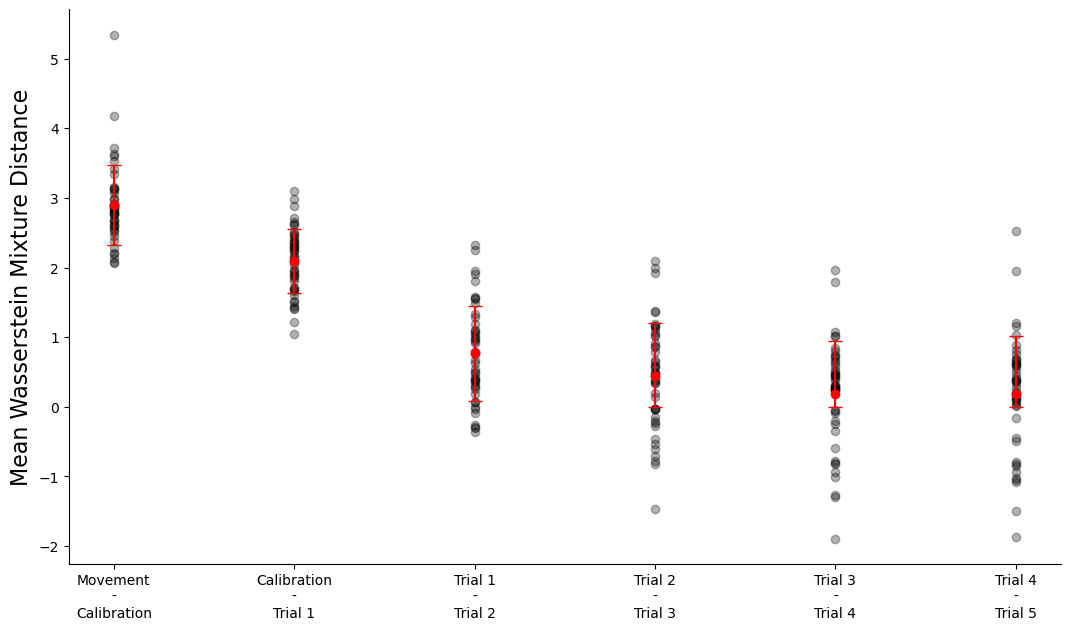

In [39]:
fig, ax = plt.subplots(1,1)
# np.log(wasserstein_subject_diffs)[np.argmax(np.log(wasserstein_subject_diffs)[:,0]),0] = 15
ax.plot(np.log(wasserstein_subject_diffs).T,"ko",alpha=0.3)
# ax.ylim(-5,50)
means = np.log(wasserstein_subject_diffs).mean(axis=(0)).reshape(-1,1)
stds = np.log(wasserstein_subject_diffs).std(axis=(0)).reshape(-1,1)

diffs = np.subtract(means,stds).reshape(-1,1)
lower_errors = np.zeros(shape=(np.log(wasserstein_subject_diffs).shape[1],1))
lower_errors[diffs < 0] = means[diffs < 0]
lower_errors[diffs > 0] = stds[diffs > 0]
y_errors = [lower_errors.ravel(),stds.ravel()]
ax.errorbar(x=range(np.log(wasserstein_subject_diffs).shape[1]),y=means.ravel(),yerr=y_errors,color="r",marker="o",capsize=5)

labels = ["Movement\n-\nCalibration","Calibration\n-\nTrial 1", "Trial 1\n-\nTrial 2", "Trial 2\n-\nTrial 3", "Trial 3\n-\nTrial 4", "Trial 4\n-\nTrial 5"]
ax.set_xticks(range(6))
ax.set_xticklabels(labels=labels)
ax.set_ylabel("Mean Wasserstein Mixture Distance")

In [19]:
plot.save_figure(fig,"wasserstein_over_tasks",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmm_diffs/wasserstein_over_tasks.pdf


Figure saved to /Users/spencer/phd/phd/images/more_results/gmm_diffs/wasserstein_over_tasks_pvalues.png


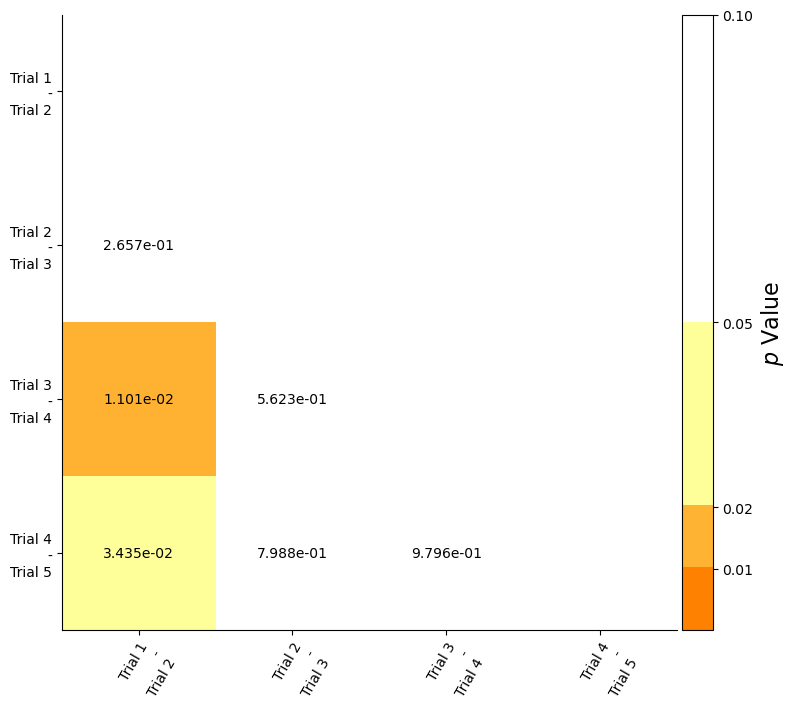

In [20]:
result = tukey_hsd(*wasserstein_subject_diffs.T[2:])
fig, ax = plt.subplots(1,1)
plot.annotated_heatmap(result.pvalue,labels_x=labels[2:],labels_y=labels[2:],figax=(fig,ax))
plot.save_figure(fig,"wasserstein_over_tasks_pvalues",image_path,format="png")

## wasserstein pairs per subject

compute wasserstein distance between adjacent models for each subject 

### lognormal models -- in the data space!

In [31]:
subject_diffs = []
for subject_idx in range(len(subjects)):
    log_models = model.load_log_trial_models(subject_idx)
    models = []
    for m in log_models:
        models.append(model.log_model(m))
    model_diffs = []
    for model_idx in range(4):
        # model x --> model y
        model_diffs.append(model.gmm_wasserstein(models[model_idx].weights,
                                                        models[model_idx+1].weights,
                                                        models[model_idx].means,
                                                        models[model_idx+1].means,
                                                        models[model_idx].covariances,
                                                        models[model_idx+1].covariances))
    subject_diffs.append(model_diffs)
    
diff_rewards = []
mean_diffs = []
for i, model_diffs in enumerate(subject_diffs):
    diff_rewards.append(mean_rewards[i])
    # mean of the differences between subsequent models
    mean_diffs.append(np.mean(model_diffs))

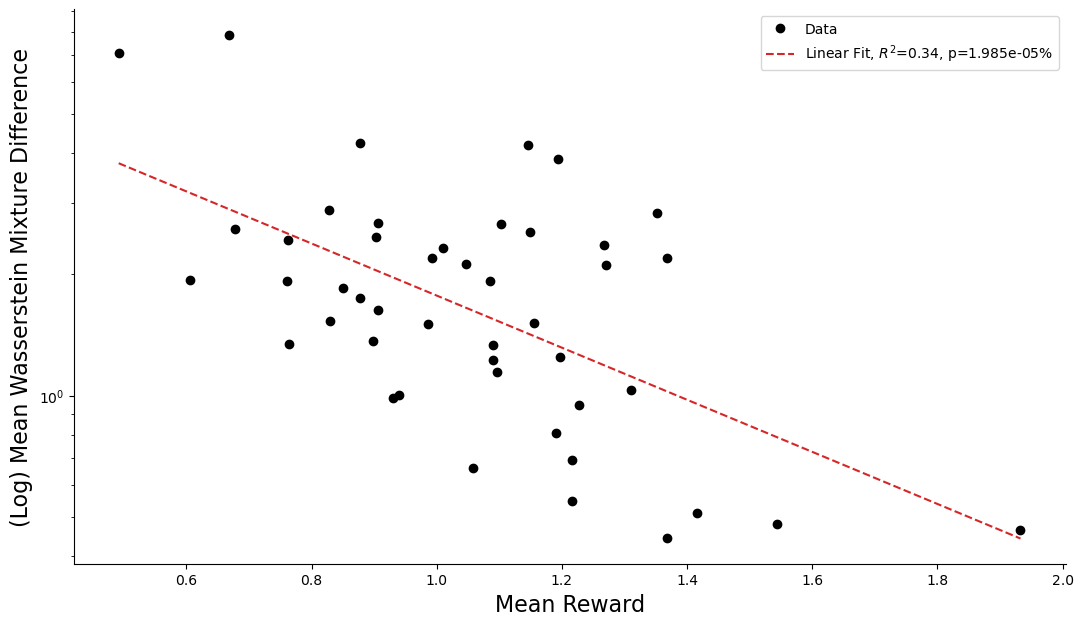

In [32]:
fig = plt.figure()
fig.tight_layout()
# norm_diff = [md/mtv for md, mtv in zip(mean_diffs,mean_total_variance)]
# i = 0
# for subject_idx in range(46):
#     plt.plot([diff_rewards[i]]*4, subject_diffs[i],"")
#     i+=1
plt.semilogy(diff_rewards,mean_diffs,"ko",label="Data")
r = analysis.linear_fit(diff_rewards,np.log(mean_diffs))
x = np.linspace(np.min(diff_rewards),np.max(diff_rewards),100)
plt.gca().plot(x, 
               np.exp(r.intercept + r.slope*x), 
               "--",
               color="tab:red",
               label=f"Linear Fit, $R^2$={plot.format_positional(r.rvalue**2)}, p={plot.format_scientific(r.pvalue)}%")
plt.ylabel("(Log) Mean Wasserstein Mixture Difference")
plt.xlabel("Mean Reward")
plt.legend()

In [24]:
plot.save_figure(fig, "mean_gmm_wasserstein", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmm_diffs/mean_gmm_wasserstein.pdf
